# CS224W Final Project Notebook
#### Miriam Farrington
#### December 2025

Description: This Colab notebook contains the code for the project **Multimodal Heterogeneous Graph Neural Networks for Predicting Adverse Device Events**.

Summary:

> This project applies heterogeneous graph neural networks (HGNNs) to post‑market surveillance of FDA‑approved medical devices by modeling adverse event relationships using openFDA Medical Device Reporting (MDR) data. The notebook constructs a heterogeneous graph over the 2024 MDR device report snapshot (January 2024), with nodes for reports, devices, manufacturers, and events, and edges such as report–mentions–device and manufacturer–makes–device. The main task is supervised link prediction on the report–mentions–device relation using compact device features and ID‑based embeddings, comparing several heterogeneous GNN architectures (including HGT and R‑GCN) under random and temporally constrained splits, with custom negative sampling and evaluation via AUROC and F1 on held‑out report–device edges.

#### Datasets Used

* MDR Data: https://www.fda.gov/medical-devices/medical-device-reporting-mdr-how-report-medical-device-problems/mdr-data-files#download



# 1) Colab Setup and Package Imports


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Clean conflicting installs first
!pip -q uninstall -y torch torchvision torchaudio torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric pyg-lib 2>/dev/null || true

# Install CUDA 12.1 build
!pip -q install --index-url https://download.pytorch.org/whl/cu121 \
  torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1

# Install PyG wheels
!pip -q install -f https://data.pyg.org/whl/torch-2.3.1+cu121.html \
  torch-scatter==2.1.2 torch-sparse==0.6.18 pyg-lib torch-geometric==2.6.1

# dependencies
!pip -q install torchmetrics==1.4.0.post0 pytorch-lightning==2.4.0 pandas pyarrow fastparquet


In [10]:
import os, pandas as pd, numpy as np, torch, torch_geometric, torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.data import HeteroData
from torch_geometric.transforms import ToUndirected, RandomLinkSplit
from torch_geometric.nn import RGCNConv, to_hetero
from torchmetrics.classification import BinaryAUROC, BinaryF1Score

In [11]:
#unzip data
!unzip -o "/content/drive/My Drive/Stanford/device2024.zip" -d "/content/drive/My Drive/Stanford/"
!unzip -o "/content/drive/My Drive/Stanford/foitext2024.zip" -d "/content/drive/My Drive/Stanford/"
# drive paths
root_dir   = "/content/drive/My Drive/Stanford"
device_fp  = os.path.join(root_dir, "DEVICE2024.txt")
foitext_fp = os.path.join(root_dir, "FOITEXT2024.txt")

Archive:  /content/drive/My Drive/Stanford/device2024.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/drive/My Drive/Stanford/device2024.zip or
        /content/drive/My Drive/Stanford/device2024.zip.zip, and cannot find /content/drive/My Drive/Stanford/device2024.zip.ZIP, period.
Archive:  /content/drive/My Drive/Stanford/foitext2024.zip
  inflating: /content/drive/My Drive/Stanford/foitext2024.txt  


In [12]:
# validations
print(torch.__version__, torch.version.cuda)
print(torch_geometric.__version__)
print("CUDA available:", torch.cuda.is_available())

2.3.1+cu121 12.1
2.6.1
CUDA available: True


##2) load + clean + create canonical keys
### starting with a minimal subgraph first
### schema:
* nodes:
  * manufacturer (MANUFACTURER_D_NAME)
  * device (combo: MANUFACTURER_D_NAME || MODEL_NUMBER || CATALOG_NUMBER || UDI-DI)
  * report (MDR_REPORT_KEY)
  * event (from DEVICE_EVENT_KEY)

* edges:
  * (manufacturer) — makes -> (device)
  * (report) — mentions -> (device)
  * (event) — involves -> (device) (created if DEVICE_EVENT_KEY exists)

* features:
  * device categorical indices: BRAND_NAME, GENERIC_NAME, DEVICE_REPORT_PRODUCT_CODE
  * device flags: IMPLANT_FLAG, COMBINATION_PRODUCT_FLAG (small embeddings)
  * manufacturer: ID embedding only
  * report/event: ID embedding only

In [23]:
# read device data
dtype_all = "string"
device_df = pd.read_csv(
    device_fp,
    sep="|",
    dtype=dtype_all,
    encoding="latin-1",
    engine="python",
    on_bad_lines="skip",
)

# initial clean up
device_df = device_df.applymap(lambda x: x.strip() if isinstance(x, str) else x).fillna("")

# date parse
for col in ["DATE_RECEIVED", "EXPIRATION_DATE_OF_DEVICE", "DATE_RETURNED_TO_MANUFACTURER"]:
    if col in device_df.columns:
        device_df[col] = pd.to_datetime(device_df[col], errors="coerce")

# ensure needed columns exist
needed = [
    "MDR_REPORT_KEY","DEVICE_EVENT_KEY","IMPLANT_FLAG","DATE_REMOVED_FLAG","DEVICE_SEQUENCE_NO","DATE_RECEIVED",
    "BRAND_NAME","GENERIC_NAME","MANUFACTURER_D_NAME","MODEL_NUMBER","CATALOG_NUMBER","LOT_NUMBER","OTHER_ID_NUMBER",
    "DEVICE_REPORT_PRODUCT_CODE","DEVICE_OPERATOR","DEVICE_EVALUATED_BY_MANUFACTUR","COMBINATION_PRODUCT_FLAG",
    "UDI-DI","UDI-PUBLIC",
]
present = [c for c in needed if c in device_df.columns]
device_df = device_df[present].copy()

# drop rows missing core IDs
device_df = device_df[
    device_df["MANUFACTURER_D_NAME"].ne("") &
    device_df["MODEL_NUMBER"].ne("")
]

# build device_key
for add in ["CATALOG_NUMBER", "UDI-DI"]:
    if add not in device_df.columns:
        device_df[add] = ""

device_df["device_key"] = (
    device_df["MANUFACTURER_D_NAME"] + "||" +
    device_df["MODEL_NUMBER"]       + "||" +
    device_df["CATALOG_NUMBER"]     + "||" +
    device_df["UDI-DI"]
).astype("string")

# build device_keys with device_id
device_keys = device_df[[
    "device_key","MANUFACTURER_D_NAME","MODEL_NUMBER","CATALOG_NUMBER","BRAND_NAME",
    "GENERIC_NAME","DEVICE_REPORT_PRODUCT_CODE","IMPLANT_FLAG","COMBINATION_PRODUCT_FLAG","UDI-DI"
]].drop_duplicates().reset_index(drop=True)
device_keys["device_id"] = np.arange(len(device_keys), dtype=np.int64)

# extract device text for embedding at device level
def make_device_text(row):
    parts = []
    if isinstance(row["BRAND_NAME"], str) and row["BRAND_NAME"]:
        parts.append(row["BRAND_NAME"])
    if isinstance(row["GENERIC_NAME"], str) and row["GENERIC_NAME"]:
        parts.append(row["GENERIC_NAME"])
    if isinstance(row["DEVICE_REPORT_PRODUCT_CODE"], str) and row["DEVICE_REPORT_PRODUCT_CODE"]:
        parts.append(f"product code {row['DEVICE_REPORT_PRODUCT_CODE']}")
    return " ; ".join(parts) if parts else "unknown medical device"

if "text_for_embed" not in device_keys.columns:
    device_keys["text_for_embed"] = device_keys.apply(make_device_text, axis=1)

# sort by device_id
device_texts = device_keys.sort_values("device_id")["text_for_embed"].tolist()

# validation
device_df.head(5)
device_keys.head(5)


/tmp/ipython-input-1835814939.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  device_df = device_df.applymap(lambda x: x.strip() if isinstance(x, str) else x).fillna("")


,device_key,MANUFACTURER_D_NAME,MODEL_NUMBER,CATALOG_NUMBER,BRAND_NAME,GENERIC_NAME,DEVICE_REPORT_PRODUCT_CODE,IMPLANT_FLAG,COMBINATION_PRODUCT_FLAG,UDI-DI,device_id,text_for_embed
0,"AIZU OLYMPUS CO., LTD.||CF-H180AL||||049531702...","AIZU OLYMPUS CO., LTD.",CF-H180AL,,EVIS EXERA II COLONOVIDEOSCOPE,COLONOVIDEOSCOPE,FDF,,N,04953170202339,0,EVIS EXERA II COLONOVIDEOSCOPE ; COLONOVIDEOSC...
1,"AIZU OLYMPUS CO., LTD.||BF-XP190||||0495317034...","AIZU OLYMPUS CO., LTD.",BF-XP190,,EVIS EXERA III BRONCHOVIDEOSCOPE,BRONCHOVIDEOSCOPE,EOQ,,N,04953170342134,1,EVIS EXERA III BRONCHOVIDEOSCOPE ; BRONCHOVIDE...
2,"AIZU OLYMPUS CO., LTD.||BF-Q290||||","AIZU OLYMPUS CO., LTD.",BF-Q290,,EVIS LUCERA ELITE BRONCHOVIDEOSCOPE,BRONCHOVIDEOSCOPE,EOQ,,N,,2,EVIS LUCERA ELITE BRONCHOVIDEOSCOPE ; BRONCHOV...
3,"INTUITIVE SURGICAL, INC||470205-17||470205||00...","INTUITIVE SURGICAL, INC",470205-17,470205,ENDOWRIST,FENESTRATED BIPOLAR FORCEPS,NAY,,N,00886874112359,3,ENDOWRIST ; FENESTRATED BIPOLAR FORCEPS ; prod...
4,"INTUITIVE SURGICAL, INC||490206-01||490206||00...","INTUITIVE SURGICAL, INC",490206-01,490206,ION,VISION PROBE,EOQ,,N,00886874121184,4,ION ; VISION PROBE ; product code EOQ


#### Load and clean the FOI Text 2024 file

In [24]:
# Load FOI text file
foi_df = pd.read_csv(foi_fp, sep='|',
                        dtype=dtype_all,
                        encoding='latin-1',
                        engine='python',
                        on_bad_lines='skip') #skip bad rows for now
# Basic cleanup
foi_df = foi_df.applymap(lambda x: x.strip() if isinstance(x, str) else x).fillna("")

# Filter to device narrative text (TEXT_TYPE_CODE == 'D')
foi_dev = foi_df[foi_df["TEXT_TYPE_CODE"] == "D"].copy()

# Aggregate all device narratives per report into a single text blob
report_text = (
    foi_dev.groupby("MDR_REPORT_KEY")["FOI_TEXT"]
    .apply(lambda s: " ".join(s.tolist()))
    .reset_index()
    .rename(columns={"MDR_REPORT_KEY": "MDR_REPORT_KEY",
                     "FOI_TEXT": "REPORT_FOI_TEXT"})
)

# Join onto existing device_df
device_df = device_df.merge(report_text, on="MDR_REPORT_KEY", how="inner")
device_df["REPORT_FOI_TEXT"] = device_df["REPORT_FOI_TEXT"].fillna("")

#validation
device_df.head(5)

/tmp/ipython-input-314965748.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  foi_df = foi_df.applymap(lambda x: x.strip() if isinstance(x, str) else x).fillna("")


,MDR_REPORT_KEY,DEVICE_EVENT_KEY,IMPLANT_FLAG,DATE_REMOVED_FLAG,DEVICE_SEQUENCE_NO,DATE_RECEIVED,BRAND_NAME,GENERIC_NAME,MANUFACTURER_D_NAME,MODEL_NUMBER,...,LOT_NUMBER,OTHER_ID_NUMBER,DEVICE_REPORT_PRODUCT_CODE,DEVICE_OPERATOR,DEVICE_EVALUATED_BY_MANUFACTUR,COMBINATION_PRODUCT_FLAG,UDI-DI,UDI-PUBLIC,device_key,REPORT_FOI_TEXT
0,18423065,,,,1,2024-01-01,EVIS EXERA II COLONOVIDEOSCOPE,COLONOVIDEOSCOPE,"AIZU OLYMPUS CO., LTD.",CF-H180AL,...,,,FDF,0HP,Y,N,04953170202339,04953170202339,"AIZU OLYMPUS CO., LTD.||CF-H180AL||||049531702...","A USER FACILITY RETURNED THE OLYMPUS ASSET, TH..."
1,18423066,,,,1,2024-01-01,EVIS EXERA III BRONCHOVIDEOSCOPE,BRONCHOVIDEOSCOPE,"AIZU OLYMPUS CO., LTD.",BF-XP190,...,,,EOQ,0HP,Y,N,04953170342134,04953170342134,"AIZU OLYMPUS CO., LTD.||BF-XP190||||0495317034...","THE CUSTOMER REPORTED TO OLYMPUS, THE EVIS EXE..."
2,18423067,,,,1,2024-01-01,EVIS LUCERA ELITE BRONCHOVIDEOSCOPE,BRONCHOVIDEOSCOPE,"AIZU OLYMPUS CO., LTD.",BF-Q290,...,,,EOQ,0HP,Y,N,,,"AIZU OLYMPUS CO., LTD.||BF-Q290||||",THE CUSTOMER REPORTED TO OLYMPUS THE BRONCHOVI...
3,18423068,,,,1,2024-01-01,ENDOWRIST,FENESTRATED BIPOLAR FORCEPS,"INTUITIVE SURGICAL, INC",470205-17,...,N10210510 0025,,NAY,0HP,Y,N,00886874112359,(01)00886874112359(11)210506(10)N10210510,"INTUITIVE SURGICAL, INC||470205-17||470205||00...",IT WAS REPORTED THAT DURING A DA VINCI-ASSISTE...
4,18423069,,,,1,2024-01-01,ION,VISION PROBE,"INTUITIVE SURGICAL, INC",490206-01,...,S14230914 0017,,EOQ,0HP,Y,N,00886874121184,(01)00886874121184(10)S14230914,"INTUITIVE SURGICAL, INC||490206-01||490206||00...",IT WAS REPORTED THAT DURING AN ION ENDOBRONCHI...


In [27]:
# Unique reports
report = pd.DataFrame({
    "MDR_REPORT_KEY": device_df["MDR_REPORT_KEY"].unique()
}).reset_index(drop=True)
report["report_id"] = np.arange(len(report), dtype=np.int64)

# Aggregate FOI text per report
report_text = (
    device_df.groupby("MDR_REPORT_KEY")["REPORT_FOI_TEXT"]
    .apply(lambda s: " ".join(s.astype(str).tolist()))
    .reset_index()
    .rename(columns={"REPORT_FOI_TEXT": "REPORT_FOI_TEXT_AGG"})
)

# Merge aggregated FOI text onto report table
report = report.merge(report_text, on="MDR_REPORT_KEY", how="left")
report["REPORT_FOI_TEXT_AGG"] = report["REPORT_FOI_TEXT_AGG"].fillna("")

# sanity check
report.head(5)

,MDR_REPORT_KEY,report_id,REPORT_FOI_TEXT_AGG
0,18423065,0,"A USER FACILITY RETURNED THE OLYMPUS ASSET, TH..."
1,18423066,1,"THE CUSTOMER REPORTED TO OLYMPUS, THE EVIS EXE..."
2,18423067,2,THE CUSTOMER REPORTED TO OLYMPUS THE BRONCHOVI...
3,18423068,3,IT WAS REPORTED THAT DURING A DA VINCI-ASSISTE...
4,18423069,4,IT WAS REPORTED THAT DURING AN ION ENDOBRONCHI...


Create Sentence Embeddings (Sentence BERT) using FOI Report Text

In [29]:
from sentence_transformers import SentenceTransformer

device_cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare texts in report_id order
report_texts = (
    report.sort_values("report_id")["REPORT_FOI_TEXT_AGG"]
    .tolist()
)

# Load SBERT and encode
sbert_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
sbert_model = sbert_model.to(device_cuda)
sbert_model.eval()

batch_size = 256
embs = []

for i in range(0, len(report_texts), batch_size):
    batch = report_texts[i:i+batch_size]
    with torch.no_grad():
        emb = sbert_model.encode(
            batch,
            convert_to_tensor=True,
            device=sbert_model.device,
            show_progress_bar=False,
        )  # [B, 384]
    embs.append(emb.cpu())

report_text_emb = torch.cat(embs, dim=0)  # [num_reports, 384]
assert report_text_emb.size(0) == len(report)
print("report_text_emb:", report_text_emb.shape)

report_text_emb: torch.Size([106497, 384])




### 3) split of the data within Jan 2024 MDR File

In [30]:
# 1) Build report-level dates and splits
report_dates = (
    device_df.groupby("MDR_REPORT_KEY")["DATE_RECEIVED"]
    .min()
    .reset_index()
    .rename(columns={"DATE_RECEIVED": "REPORT_DATE"})
)

min_date = report_dates["REPORT_DATE"].min()
max_date = report_dates["REPORT_DATE"].max()
print("REPORT_DATE range:", min_date, "->", max_date)

train_cutoff = min_date + (max_date - min_date) * 0.70
val_cutoff   = min_date + (max_date - min_date) * 0.85

def assign_report_split(ts):
    if pd.isna(ts):
        return "drop"
    if ts <= train_cutoff:
        return "train"
    elif ts <= val_cutoff:
        return "val"
    else:
        return "test"

report_dates["split"] = report_dates["REPORT_DATE"].apply(assign_report_split)
report_dates = report_dates[report_dates["split"] != "drop"]

# 2) Merge splits back into device_df
device_df = device_df.merge(
    report_dates[["MDR_REPORT_KEY", "split"]],
    on="MDR_REPORT_KEY",
    how="inner",
)

print(device_df["split"].value_counts())
train_rows = device_df[device_df["split"] == "train"].copy()
val_rows   = device_df[device_df["split"] == "val"].copy()
test_rows  = device_df[device_df["split"] == "test"].copy()


REPORT_DATE range: 2024-01-01 00:00:00 -> 2024-01-30 00:00:00
split
train    73387
val      21653
test     11457
Name: count, dtype: int64


### Choose a target relation for the Link Prediction Task

In [31]:
# Choose target relation to predict from the AVAILABLE_RELS list:

AVAILABLE_RELS = [
    ("report","mentions","device"),
    ("manufacturer","makes","device"),
    ("event","involves","device"),
]

TARGET_REL = ("report","mentions","device")
assert TARGET_REL in AVAILABLE_RELS, f"{TARGET_REL} not in available relations"
REL = TARGET_REL
print("Target link prediction relation:", REL)


Target link prediction relation: ('report', 'mentions', 'device')


## 4) create node tables + id maps

In [32]:
## 4) create node tables + id maps (post temporal split)

# manufacturers
manuf = pd.DataFrame({"manufacturer_name": device_df["MANUFACTURER_D_NAME"].unique()})
manuf["manufacturer_id"] = np.arange(len(manuf), dtype=np.int64)

# devices (unique by canonical device_key + metadata)
device_keys = device_df[[
    "device_key","MANUFACTURER_D_NAME","MODEL_NUMBER","CATALOG_NUMBER","BRAND_NAME",
    "GENERIC_NAME","DEVICE_REPORT_PRODUCT_CODE","IMPLANT_FLAG","COMBINATION_PRODUCT_FLAG","UDI-DI"
]].drop_duplicates()
device_keys = device_keys.reset_index(drop=True)
device_keys["device_id"] = np.arange(len(device_keys), dtype=np.int64)

# reports
report = pd.DataFrame({"report_key": device_df["MDR_REPORT_KEY"].unique()})
report["report_id"] = np.arange(len(report), dtype=np.int64)

# events (if available)
if "DEVICE_EVENT_KEY" in device_df.columns and device_df["DEVICE_EVENT_KEY"].ne("").any():
    event = pd.DataFrame({"event_key": device_df["DEVICE_EVENT_KEY"].replace("", np.nan).dropna().unique()})
else:
    event = pd.DataFrame({"event_key": ["UNK"]})
event["event_id"] = np.arange(len(event), dtype=np.int64)

# map back to main df
device_df = device_df.merge(manuf, left_on="MANUFACTURER_D_NAME",
                            right_on="manufacturer_name", how="left")

device_df = device_df.merge(device_keys[["device_key","device_id"]],
                            on="device_key", how="left")

device_df = device_df.merge(report, left_on="MDR_REPORT_KEY",
                            right_on="report_key", how="left")

device_df["event_key"] = device_df["DEVICE_EVENT_KEY"].replace("", "UNK")
device_df = device_df.merge(event, on="event_key", how="left")


## 5) build edges

In [33]:
def to_edge_index(df):
    if df.empty:
        return torch.empty(2, 0, dtype=torch.long)
    return torch.tensor(df.values.T, dtype=torch.long)

# global edges
md = device_df[["manufacturer_id","device_id"]].drop_duplicates()
edge_manuf_device = torch.tensor(md[["manufacturer_id","device_id"]].values.T,
                                 dtype=torch.long)

ed = device_df[["event_id","device_id"]].drop_duplicates()
edge_event_device = torch.tensor(ed[["event_id","device_id"]].values.T,
                                 dtype=torch.long)

temporal_edges = {}

#build edges corresponding to selected target relation
if REL == ("report","mentions","device"):
    rd_train = device_df[device_df["split"] == "train"][["report_id","device_id"]].drop_duplicates()
    rd_val   = device_df[device_df["split"] == "val"][["report_id","device_id"]].drop_duplicates()
    rd_test  = device_df[device_df["split"] == "test"][["report_id","device_id"]].drop_duplicates()

    edge_report_device_train = to_edge_index(rd_train)
    edge_report_device_val   = to_edge_index(rd_val)
    edge_report_device_test  = to_edge_index(rd_test)

    temporal_edges["train"] = edge_report_device_train
    temporal_edges["val"]   = edge_report_device_val
    temporal_edges["test"]  = edge_report_device_test

    print("report->device edges:",
          "train", edge_report_device_train.size(1),
          "val",   edge_report_device_val.size(1),
          "test",  edge_report_device_test.size(1))

elif REL == ("manufacturer","makes","device"):
    md_train = device_df[device_df["split"] == "train"][["manufacturer_id","device_id"]].drop_duplicates()
    md_val   = device_df[device_df["split"] == "val"][["manufacturer_id","device_id"]].drop_duplicates()
    md_test  = device_df[device_df["split"] == "test"][["manufacturer_id","device_id"]].drop_duplicates()

    edge_manuf_device_train = to_edge_index(md_train)
    edge_manuf_device_val   = to_edge_index(md_val)
    edge_manuf_device_test  = to_edge_index(md_test)

    temporal_edges["train"] = edge_manuf_device_train
    temporal_edges["val"]   = edge_manuf_device_val
    temporal_edges["test"]  = edge_manuf_device_test

    print("manufacturer->device edges:",
          "train", edge_manuf_device_train.size(1),
          "val",   edge_manuf_device_val.size(1),
          "test",  edge_manuf_device_test.size(1))

elif REL == ("event","involves","device"):
    ed_train = device_df[device_df["split"] == "train"][["event_id","device_id"]].drop_duplicates()
    ed_val   = device_df[device_df["split"] == "val"][["event_id","device_id"]].drop_duplicates()
    ed_test  = device_df[device_df["split"] == "test"][["event_id","device_id"]].drop_duplicates()

    edge_event_device_train = to_edge_index(ed_train)
    edge_event_device_val   = to_edge_index(ed_val)
    edge_event_device_test  = to_edge_index(ed_test)

    temporal_edges["train"] = edge_event_device_train
    temporal_edges["val"]   = edge_event_device_val
    temporal_edges["test"]  = edge_event_device_test

    print("event->device edges:",
          "train", edge_event_device_train.size(1),
          "val",   edge_event_device_val.size(1),
          "test",  edge_event_device_test.size(1))

else:
    raise ValueError(f"Unsupported TARGET_REL={REL}")

report->device edges: train 190783 val 50992 test 28319


## 6) Embedded features

In [34]:
# categorical vocabularies (from device table)
brand_vocab   = pd.Series(device_keys["BRAND_NAME"].astype("category").cat.categories)
generic_vocab = pd.Series(device_keys["GENERIC_NAME"].astype("category").cat.categories)
prod_vocab    = pd.Series(device_keys["DEVICE_REPORT_PRODUCT_CODE"].astype("category").cat.categories)

brand2ix   = {b: i for i, b in enumerate(brand_vocab)}
generic2ix = {g: i for i, g in enumerate(generic_vocab)}
prod2ix    = {p: i for i, p in enumerate(prod_vocab)}

# map to indices using device_keys (one row per device_id)
dev_feat = pd.DataFrame(index=device_keys["device_id"])
dev_feat["brand_ix"]   = device_keys["BRAND_NAME"].map(brand2ix).fillna(-1).astype(int)
dev_feat["generic_ix"] = device_keys["GENERIC_NAME"].map(generic2ix).fillna(-1).astype(int)
dev_feat["prod_ix"]    = device_keys["DEVICE_REPORT_PRODUCT_CODE"].map(prod2ix).fillna(-1).astype(int)

# flag indices
flag_map = {"Y": 1, "N": 0, "": 0}
dev_feat["implant_flag"] = device_keys["IMPLANT_FLAG"].map(lambda x: flag_map.get(str(x).upper(), 0)).astype(int)
dev_feat["combo_flag"]   = device_keys["COMBINATION_PRODUCT_FLAG"].map(lambda x: flag_map.get(str(x).upper(), 0)).astype(int)

# tensors: device has 5 feature columns, others just ID indices
device_x = torch.tensor(
    dev_feat[["brand_ix","generic_ix","prod_ix","implant_flag","combo_flag"]].values,
    dtype=torch.long,
)
manuf_x  = torch.arange(len(manuf),  dtype=torch.long).unsqueeze(1)
report_x = torch.arange(len(report), dtype=torch.long).unsqueeze(1)
event_x  = torch.arange(len(event),  dtype=torch.long).unsqueeze(1)


#### 7) Set bounds on feature indices and split for train/val/test

In [35]:
# bounds on device feature indices
B = max(1, len(brand2ix))
G = max(1, len(generic2ix))
P = max(1, len(prod2ix))

if device_x.numel() > 0:
    device_x[:, 0] = torch.clamp(device_x[:, 0], 0, B-1)  # brand_ix
    device_x[:, 1] = torch.clamp(device_x[:, 1], 0, G-1)  # generic_ix
    device_x[:, 2] = torch.clamp(device_x[:, 2], 0, P-1)  # prod_ix
    device_x[:, 3] = torch.clamp(device_x[:, 3], 0, 1)    # implant_flag
    device_x[:, 4] = torch.clamp(device_x[:, 4], 0, 1)    # combo_flag


train_rows = device_df[device_df["split"] == "train"].copy()
val_rows   = device_df[device_df["split"] == "val"].copy()
test_rows  = device_df[device_df["split"] == "test"].copy()

print("rows per split:",
      "train", len(train_rows),
      "val",   len(val_rows),
      "test",  len(test_rows))

rows per split: train 190783 val 50992 test 28319


## 8) build HeteroData + split for link prediction

In [36]:
from torch_geometric.data import HeteroData

data = HeteroData()

# Node counts from node tables
num_reports = len(report)          # report_id 0..num_reports-1
num_devices = len(device_keys)     # device_id 0..num_devices-1
num_mfrs    = len(manuf)           # manufacturer_id 0..num_mfrs-1

data["report"].num_nodes       = num_reports
data["device"].num_nodes       = num_devices
data["manufacturer"].num_nodes = num_mfrs

def build_edge_index(df, src_col, dst_col):
    if df.empty:
        return torch.empty(2, 0, dtype=torch.long)
    src = torch.as_tensor(df[src_col].values, dtype=torch.long)
    dst = torch.as_tensor(df[dst_col].values, dtype=torch.long)
    return torch.stack([src, dst], dim=0)

if REL == ("report","mentions","device"):
    train_edges_df = train_rows[["report_id","device_id"]].drop_duplicates()
    val_edges_df   = val_rows[["report_id","device_id"]].drop_duplicates()
    test_edges_df  = test_rows[["report_id","device_id"]].drop_duplicates()
    src_nt, dst_nt = "report", "device"
    src_col, dst_col = "report_id", "device_id"

elif REL == ("manufacturer","makes","device"):
    train_edges_df = mfr_train_rows[["manufacturer_id","device_id"]].drop_duplicates()
    val_edges_df   = mfr_val_rows[["manufacturer_id","device_id"]].drop_duplicates()
    test_edges_df  = mfr_test_rows[["manufacturer_id","device_id"]].drop_duplicates()
    src_nt, dst_nt = "manufacturer", "device"
    src_col, dst_col = "manufacturer_id", "device_id"

else:
    raise ValueError(f"Unsupported TARGET_REL={REL}")

edge_train = build_edge_index(train_edges_df, src_col, dst_col)
edge_val   = build_edge_index(val_edges_df,   src_col, dst_col)
edge_test  = build_edge_index(test_edges_df,  src_col, dst_col)

# Set target relation edges on the graph
data[src_nt, REL[1], dst_nt].edge_index = edge_train
data[dst_nt, f"rev_{REL[1]}", src_nt].edge_index = edge_train.flip(0)

# manufacturer -> device
mfr_dev_all = build_edge_index(
    device_df[["manufacturer_id","device_id"]].drop_duplicates(),
    "manufacturer_id", "device_id"
)
data["manufacturer", "makes", "device"].edge_index = mfr_dev_all
data["device", "made_by", "manufacturer"].edge_index = mfr_dev_all.flip(0)

temporal_edges = {
    "train": edge_train,
    "val":   edge_val,
    "test":  edge_test,
}

print(f"edge counts {REL[0]}->{REL[2]}:",
      "train", edge_train.size(1),
      "val",   edge_val.size(1),
      "test",  edge_test.size(1))


edge counts report->device: train 190783 val 50992 test 28319


### Build utilities for negative edge sampling

In [37]:
num_reports = data["report"].num_nodes
num_devices = data["device"].num_nodes

# build a set of observed positive pairs for masking
def build_obs_set(edge_index):
    # edge_index: [2, E]
    return set(map(tuple, edge_index.t().tolist()))

pos_train = edge_train
pos_val   = edge_val
pos_test  = edge_test

obs_train = build_obs_set(pos_train)
obs_val   = build_obs_set(pos_val)
obs_test  = build_obs_set(pos_test)

def sample_negatives_masked(num_src, num_dst, num_neg, obs_pairs, device):
    neg = []
    while len(neg) < num_neg:
        src = np.random.randint(0, num_src)
        dst = np.random.randint(0, num_dst)
        if (src, dst) not in obs_pairs:
            neg.append((src, dst))
    neg = torch.tensor(neg, dtype=torch.long, device=device).t()  # [2, num_neg]
    return neg

neg_train = sample_negatives_masked(num_reports, num_devices,
                                    int(pos_train.size(1) * 0.5),
                                    obs_train, pos_train.device)
neg_val   = sample_negatives_masked(num_reports, num_devices,
                                    int(pos_val.size(1) * 0.5),
                                    obs_val, pos_val.device)
neg_test  = sample_negatives_masked(num_reports, num_devices,
                                    int(pos_test.size(1) * 0.5),
                                    obs_test, pos_test.device)




####Sanity Checks on built graph data

In [38]:
def check_graph(data):
    print("Node stores")
    for ntype in data.node_types:
        assert hasattr(data[ntype], 'num_nodes'), f"{ntype} missing num_nodes"
        N = int(data[ntype].num_nodes)
        XN = None
        if 'x' in data[ntype]:
            XN = int(data[ntype].x.size(0))
            ok = (XN == N)
            print(f"{ntype:12s} num_nodes={N:,}  x_rows={XN:,}  ok={ok}")
        else:
            print(f"{ntype:12s} num_nodes={N:,}  x_rows=None")

    print("Edge stores")
    for et in data.edge_types:
        ei = data[et].edge_index
        src, rel, dst = et
        Nsrc = int(data[src].num_nodes); Ndst = int(data[dst].num_nodes)
        smax = int(ei[0].max()) if ei.numel() else -1
        dmax = int(ei[1].max()) if ei.numel() else -1
        ok = (ei.numel()==0) or (smax < Nsrc and dmax < Ndst)
        print(f"{src:12s}-{rel:12s}->{dst:12s}  E={ei.size(1):,}  smax={smax}<{Nsrc}  dmax={dmax}<{Ndst}  ok={ok}")

check_graph(data)


Node stores
report       num_nodes=106,497  x_rows=None
device       num_nodes=13,850  x_rows=None
manufacturer num_nodes=897  x_rows=None
Edge stores
report      -mentions    ->device        E=190,783  smax=76271<106497  dmax=13847<13850  ok=True
device      -rev_mentions->report        E=190,783  smax=13847<13850  dmax=76271<106497  ok=True
manufacturer-makes       ->device        E=13,850  smax=896<897  dmax=13849<13850  ok=True
device      -made_by     ->manufacturer  E=13,850  smax=13849<13850  dmax=896<897  ok=True


## 8b) Attach node features to existing HeteroData and add reverse edges

In [60]:
from torch_geometric.transforms import ToUndirected

# Attach node features to the already-created data
data["manufacturer"].x = manuf_x.clone()
data["report"].x       = report_x.clone()
data["event"].x        = event_x.clone()
data["device"].x       = device_x.clone()

# Make graph undirected: add reverse edge types for all relations
data = ToUndirected()(data)

## 9) Use LinkNeighborLoader to build loaders that sample neighbors on the train graph


In [61]:
import os
import torch.multiprocessing as mp
from torch_geometric.loader import LinkNeighborLoader

mp.set_sharing_strategy("file_system")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


In [72]:
print("Target relation:", REL)

# Use temporal split edges as positives
train_pos = edge_train
val_pos   = edge_val
test_pos  = edge_test

print(f"train={train_pos.size(1):,}  val={val_pos.size(1):,}  test={test_pos.size(1):,}")

# fanouts: sample neighbors around the target edges
fanouts = {et: [0] for et in data.edge_types}  # 0-hop
fanouts[REL] = [2]
rev_rel = (REL[2], f"rev_{REL[1]}", REL[0])
if rev_rel in fanouts:
    fanouts[rev_rel] = [2]

def make_loader(edge_index_pos, batch_size, shuffle):
    return LinkNeighborLoader(
        data=data,
        num_neighbors=fanouts,
        edge_label_index=(REL, edge_index_pos),
        neg_sampling_ratio=0.5,
        batch_size=batch_size,
        shuffle=shuffle,
        replace=False,
        pin_memory=False,
        num_workers=0,
        persistent_workers=False,
    )

train_loader = make_loader(train_pos, batch_size=512,  shuffle=True)
val_loader   = make_loader(val_pos,   batch_size=1024, shuffle=False)
test_loader  = make_loader(test_pos,  batch_size=1024, shuffle=False)

# smoke test
b = next(iter(train_loader))
print("Batch node counts:", {nt: int(b[nt].num_nodes) for nt in b.node_types})
for nt, x in b.x_dict.items():
    print(f"{nt:10s} x.shape={tuple(x.shape)}")


Target relation: ('report', 'mentions', 'device')
train=190,783  val=50,992  test=28,319
Batch node counts: {'report': 1433, 'device': 812, 'manufacturer': 0, 'event': 0}
report     x.shape=(1433, 1)
device     x.shape=(812, 5)
manufacturer x.shape=(0, 1)
event      x.shape=(0, 1)


#### Create Embeddings

In [98]:
import torch, torch.nn as nn, torch.nn.functional as F
from torchmetrics.classification import BinaryAUROC, BinaryF1Score


EMB = 16
amp_dtype = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16


class FeatureEmbedder(nn.Module):
    def __init__(self, num_manuf, brand_sz, gen_sz, prod_sz, num_report, num_event, emb=EMB):
        super().__init__()
        self.manuf_emb = nn.Embedding(max(1, num_manuf), emb)
        self.report_emb= nn.Embedding(max(1, num_report), emb)
        self.event_emb = nn.Embedding(max(1, num_event),  emb)
        self.brand_emb = nn.Embedding(max(1, brand_sz),  emb)
        self.gen_emb   = nn.Embedding(max(1, gen_sz),    emb)
        self.prod_emb  = nn.Embedding(max(1, prod_sz),   emb)
        self.implant_emb = nn.Embedding(2, max(1, emb // 4))
        self.combo_emb   = nn.Embedding(2, max(1, emb // 4))
        concat_dim = emb*3 + 2*max(1, emb//4)
        self.dev_proj = nn.Linear(concat_dim, emb)

        # New: projections for SBERT-style text embeddings (384 -> emb)
        self.device_text_proj = nn.Linear(384, emb)
        self.report_text_proj = nn.Linear(384, emb)

    def forward(self, x_dict):
        out = {}

        # Manufacturer
        if "manufacturer" in x_dict:
            out["manufacturer"] = self.manuf_emb(x_dict["manufacturer"].squeeze(-1))

        # Report id embedding
        if "report" in x_dict:
            rep_id_emb = self.report_emb(x_dict["report"].squeeze(-1))
            if "report_text" in x_dict:
                rep_txt = x_dict["report_text"]          # [N_report, 384], float
                rep_txt_emb = self.report_text_proj(rep_txt)
                out["report"] = rep_id_emb + rep_txt_emb
            else:
                out["report"] = rep_id_emb

        # Event
        if "event" in x_dict:
            out["event"] = self.event_emb(x_dict["event"].squeeze(-1))

        # Device
        if "device" in x_dict:
            d = x_dict["device"]  # [N_dev, 5] long
            brand   = self.brand_emb(torch.clamp(d[:,0], min=0))
            generic = self.gen_emb(torch.clamp(d[:,1],   min=0))
            prod    = self.prod_emb(torch.clamp(d[:,2],  min=0))
            implant = self.implant_emb(torch.clamp(d[:,3], 0, 1))
            combo   = self.combo_emb(torch.clamp(d[:,4], 0, 1))
            dev_cat = torch.cat([brand, generic, prod, implant, combo], dim=1)
            dev_id_emb = self.dev_proj(dev_cat)  # [N_dev, emb]

            if "device_text" in x_dict:
                dev_txt = x_dict["device_text"]        # [N_dev, 384], float
                dev_txt_emb = self.device_text_proj(dev_txt)
                out["device"] = dev_id_emb + dev_txt_emb
            else:
                out["device"] = dev_id_emb

        return out


def prune_batch_dicts(x_dict, edge_index_dict):
    keep_nodes = {nt for nt, x in x_dict.items() if x.size(0) > 0}
    x_pruned = {nt: x for nt, x in x_dict.items() if nt in keep_nodes}
    ei_pruned = {}
    for et, ei in edge_index_dict.items():
        if ei.numel()==0:
            continue
        src, _, dst = et
        if src in keep_nodes and dst in keep_nodes:
            ei_pruned[et] = ei
    return x_pruned, ei_pruned


sizes = (len(manuf), len(brand2ix), len(generic2ix),
         len(prod2ix), len(report), len(event))

bce = nn.BCEWithLogitsLoss()
auroc = BinaryAUROC().to(device_cuda)
f1 = BinaryF1Score().to(device_cuda)


### 9b) Model Class Definitions

###HAN-LP (relation‑level attention)

In [99]:
from torch_geometric.nn import HANConv
import torch.nn as nn
import torch.nn.functional as F

class HAN_LP(nn.Module):
    def __init__(self, metadata, sizes, emb=EMB, heads=4):
        super().__init__()
        (num_manuf, brand_sz, gen_sz, prod_sz, num_report, num_event) = sizes

        self.fe = FeatureEmbedder(num_manuf, brand_sz, gen_sz, prod_sz,
                                  num_report, num_event, emb=emb)

        self.han = HANConv(
            in_channels=emb,
            out_channels=emb,
            metadata=metadata,
            heads=heads,
        )

        self.scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x_dict, edge_index_dict):
        x = self.fe(x_dict)
        x, edge_index_dict = prune_batch_dicts(x, edge_index_dict)
        if len(edge_index_dict) == 0:
            return x
        x = {k: F.relu(v).to(torch.float32) for k, v in x.items()}
        with torch.cuda.amp.autocast(enabled=False):
            x = self.han(x_dict=x, edge_index_dict=edge_index_dict)
            x = {k: F.relu(v) for k, v in x.items()}
        return x

    def predict(self, x, edge_index, rel):
        src, dst = rel[0], rel[2]
        if (src not in x) or (dst not in x) or (edge_index.numel() == 0):
            return torch.empty(0, device=list(x.values())[0].device if len(x) else "cpu")
        h_src = x[src][edge_index[0]]
        h_dst = x[dst][edge_index[1]]
        return self.scale * (h_src * h_dst).sum(-1)

###Simple-HAN

In [100]:

class SimpleHAN_LP(nn.Module):
    """
    HAN-style hetero encoder:
      - One shared linear per edge type to map neighbor features
      - Aggregate neighbor messages per relation
      - Attention over relation-level messages for each node type
      - Dot-product link predictor, same API as HGT_LP
    """
    def __init__(self, metadata, sizes, emb=EMB, heads=4):
        super().__init__()
        (num_manuf, brand_sz, gen_sz, prod_sz, num_report, num_event) = sizes

        self.fe = FeatureEmbedder(num_manuf, brand_sz, gen_sz, prod_sz,
                                  num_report, num_event, emb=emb)

        node_types, edge_types = metadata
        self.node_types = list(node_types)
        self.edge_types = list(edge_types)
        self.emb = emb
        self.heads = heads
        self.head_dim = emb // heads

        # linear transforms per edge type (relation-specific message functions)
        self.rel_lin = nn.ModuleDict()
        for (src, rel, dst) in self.edge_types:
            key = f"{src}__{rel}__{dst}"
            self.rel_lin[key] = nn.Linear(emb, emb, bias=False)

        # attention parameters: one query per (dst node type, relation)
        self.att_dst = nn.ModuleDict()
        for nt in self.node_types:
            self.att_dst[nt] = nn.Linear(emb, emb, bias=False)

        # relation embeddings for attention keys
        self.rel_att = nn.ParameterDict()
        for (src, rel, dst) in self.edge_types:
            key = f"{src}__{rel}__{dst}"
            self.rel_att[key] = nn.Parameter(torch.randn(emb))

        self.scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x_dict, edge_index_dict):
      # initial embeddings
      x = self.fe(x_dict)
      x, edge_index_dict = prune_batch_dicts(x, edge_index_dict)
      if len(edge_index_dict) == 0:
          return x

      x = {k: F.relu(v).to(torch.float32) for k, v in x.items()}

      # for each destination node type, collect relation-level messages
      rel_msgs_per_dst = {nt: [] for nt in self.node_types}
      rel_keys_per_dst = {nt: [] for nt in self.node_types}

      for (src_nt, rel_name, dst_nt) in self.edge_types:
          et = (src_nt, rel_name, dst_nt)
          if et not in edge_index_dict:
              continue
          if (src_nt not in x) or (dst_nt not in x):
              continue

          ei = edge_index_dict[et]  # [2, E]
          if ei.numel() == 0:
              continue

          key = f"{src_nt}__{rel_name}__{dst_nt}"

          h_src = x[src_nt]
          h_dst = x[dst_nt]

          # linear transform on source features
          m_src = self.rel_lin[key](h_src)
          m_src = m_src.to(torch.float32)

          src_idx = ei[0]
          dst_idx = ei[1]

          # aggregate messages to dst nodes
          m = torch.zeros_like(h_dst)
          m.index_add_(0, dst_idx, m_src[src_idx])

          deg = torch.zeros(h_dst.size(0), device=h_dst.device, dtype=torch.float32)
          deg.index_add_(0, dst_idx, torch.ones_like(dst_idx, dtype=torch.float32))
          deg = deg.clamp(min=1.0).unsqueeze(-1)
          m = m / deg  # [N_dst, emb]

          rel_msgs_per_dst[dst_nt].append(m)
          rel_keys_per_dst[dst_nt].append(key)

      # for each dst node type, apply attention over relation messages
      out = {}
      for dst_nt, msgs in rel_msgs_per_dst.items():
          if dst_nt not in x:
              continue
          h_dst = x[dst_nt]  # [N, emb], float32

          if len(msgs) == 0:
              # keep original embedding
              out[dst_nt] = h_dst
              continue

          # stack relation messages: [R, N, emb]
          M = torch.stack(msgs, dim=0)
          R, N, D = M.shape

          q = self.att_dst[dst_nt](h_dst)  # [N, emb]

          # relation keys: [R, emb]
          rel_keys = torch.stack([self.rel_att[k] for k in rel_keys_per_dst[dst_nt]], dim=0)

          # attention logits: [R, N]
          att_logits = torch.matmul(rel_keys, q.t()) / (D ** 0.5)
          att_weights = F.softmax(att_logits, dim=0)

          # weighted sum of messages: [N, emb]
          att_expanded = att_weights.unsqueeze(-1)  # [R, N, 1]
          h_out = (att_expanded * M).sum(dim=0)     # [N, emb]
          out[dst_nt] = F.relu(h_out)

      return out


    def predict(self, x, edge_index, rel):
        src, dst = rel[0], rel[2]
        if (src not in x) or (dst not in x) or (edge_index.numel() == 0):
            return torch.empty(0, device=list(x.values())[0].device if len(x) else "cpu")
        h_src = x[src][edge_index[0]]
        h_dst = x[dst][edge_index[1]]
        return self.scale * (h_src * h_dst).sum(-1)


### HGT-CONV

In [101]:
from torch_geometric.nn import HGTConv

HGT_HEADS = 1

class HGT_LP(nn.Module):
    def __init__(self, metadata, sizes, heads=HGT_HEADS, emb=EMB):
        super().__init__()
        (num_manuf, brand_sz, gen_sz, prod_sz, num_report, num_event) = sizes
        self.fe = FeatureEmbedder(num_manuf, brand_sz, gen_sz, prod_sz, num_report, num_event, emb=emb)
        self.hgt = HGTConv(in_channels=emb, out_channels=emb, metadata=metadata, heads=heads)
        self.scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, x_dict, edge_index_dict):
        x = self.fe(x_dict)
        x, edge_index_dict = prune_batch_dicts(x, edge_index_dict)
        if len(edge_index_dict) == 0:
            return x
        x = {k: F.relu(v).to(torch.float32) for k, v in x.items()}
        with torch.cuda.amp.autocast(enabled=False):
            x = self.hgt(x, edge_index_dict)
            x = {k: F.relu(v) for k, v in x.items()}
        return x

    def predict(self, x, edge_index, rel):
        src, dst = rel[0], rel[2]
        if (src not in x) or (dst not in x) or (edge_index.numel()==0):
            return torch.empty(0, device=list(x.values())[0].device if len(x) else "cpu")
        h_src = x[src][edge_index[0]]
        h_dst = x[dst][edge_index[1]]
        return self.scale * (h_src * h_dst).sum(-1)


###R-GCN

In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class RGCN_LP(nn.Module):
    def __init__(self, metadata, sizes, emb=EMB, hidden=None):
        super().__init__()
        if hidden is None:
            hidden = emb

        (num_manuf, brand_sz, gen_sz, prod_sz, num_report, num_event) = sizes
        self.fe = FeatureEmbedder(num_manuf, brand_sz, gen_sz, prod_sz,
                                  num_report, num_event, emb=emb)

        node_types, edge_types = metadata
        self.node_types = list(node_types)
        self.edge_types = list(edge_types)

        # map each node type to a global id range
        self.nt_offsets = {}
        offset = 0
        for nt in self.node_types:
            self.nt_offsets[nt] = offset
            offset += 1_000_000_000

        # relation id for each edge type
        self.rel2id = {et: i for i, et in enumerate(self.edge_types)}
        num_rel = len(self.edge_types)

        self.conv1 = RGCNConv(emb, hidden, num_relations=num_rel)
        self.conv2 = RGCNConv(hidden, emb, num_relations=num_rel)

        self.scale = nn.Parameter(torch.tensor(1.0))

    def _build_homogeneous(self, x_dict, edge_index_dict):
        # x_dict: {nt: [N_nt, emb]}
        nt_slices = {}
        cur = 0
        for nt, x in x_dict.items():
            N = x.size(0)
            nt_slices[nt] = (cur, cur + N)
            cur += N

        # concatenate node features
        x_cat = torch.cat([x_dict[nt] for nt in self.node_types if nt in x_dict], dim=0)

        # build homogeneous edge_index and edge_type tensors
        edge_index_list = []
        edge_type_list = []
        for et in self.edge_types:
            if et not in edge_index_dict:
                continue
            src_nt, _, dst_nt = et
            if src_nt not in nt_slices or dst_nt not in nt_slices:
                continue
            ei = edge_index_dict[et]
            src_off, _ = nt_slices[src_nt]
            dst_off, _ = nt_slices[dst_nt]
            edge_index_list.append(torch.stack([
                ei[0] + src_off,
                ei[1] + dst_off,
            ], dim=0))
            edge_type_list.append(
                torch.full((ei.size(1),), self.rel2id[et],
                           dtype=torch.long, device=ei.device)
            )

        if len(edge_index_list) == 0:
            return x_cat, None, None, nt_slices

        edge_index = torch.cat(edge_index_list, dim=1)
        edge_type  = torch.cat(edge_type_list, dim=0)
        return x_cat, edge_index, edge_type, nt_slices

    def forward(self, x_dict, edge_index_dict):
        # embed hetero features
        x = self.fe(x_dict)
        x, edge_index_dict = prune_batch_dicts(x, edge_index_dict)
        if len(edge_index_dict) == 0:
            return x
        x = {k: F.relu(v).to(torch.float32) for k, v in x.items()}

        x_cat, edge_index, edge_type, nt_slices = self._build_homogeneous(x, edge_index_dict)
        if edge_index is None:
            return x

        with torch.cuda.amp.autocast(enabled=False):
            h = self.conv1(x_cat, edge_index, edge_type)
            h = F.relu(h)
            h = self.conv2(h, edge_index, edge_type)
            h = F.relu(h)

        # split back to hetero dict
        out = {}
        for nt, (s, e) in nt_slices.items():
            out[nt] = h[s:e]
        return out

    def predict(self, x, edge_index, rel):
        src, dst = rel[0], rel[2]
        if (src not in x) or (dst not in x) or (edge_index.numel() == 0):
            return torch.empty(0, device=list(x.values())[0].device if len(x) else "cpu")
        h_src = x[src][edge_index[0]]
        h_dst = x[dst][edge_index[1]]
        return self.scale * (h_src * h_dst).sum(-1)


In [103]:
def to_device_batch(batch, device):
    # move base node features and edges
    x  = {k: v.to(device, non_blocking=True) for k, v in batch.x_dict.items()}
    ei = {k: v.to(device, non_blocking=True) for k, v in batch.edge_index_dict.items()}

    # Attach text embeddings using the local node id -> global id mapping from the batch
    # For LinkNeighborLoader on HeteroData, each node type has a `batch[nt].n_id`
    if hasattr(batch, "n_id"):
        batch.n_id = batch.n_id.to(device, non_blocking=True)
    if hasattr(batch, "input_id"):
        batch.input_id = batch.input_id.to(device, non_blocking=True)

    # Device text
    if "device" in batch:
        dev_global_ids = batch["device"].n_id.cpu().numpy()
        x["device_text"] = device_text_emb[dev_global_ids].to(device, non_blocking=True)

    # Report text
    if "report" in batch:
        rep_global_ids = batch["report"].n_id.cpu().numpy()
        x["report_text"] = report_text_emb[rep_global_ids].to(device, non_blocking=True)

    return x, ei


###Train Models (HAN_LP, Simple HAN, HGT, RGCN

In [104]:
# global training hyperparameters
LR = 1e-3
WD = 1e-4
use_amp_globally = torch.cuda.is_available()

def make_optimizer(model, lr=LR, wd=WD):
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.cuda.amp.GradScaler(
        enabled=use_amp_globally and not isinstance(model, SimpleHAN_LP)
    )
    return opt, scaler


In [105]:
from sklearn.metrics import f1_score

def best_f1_threshold(probs, labels, num_steps=19):
    """
    probs, labels: 1D torch tensors on CPU
    Returns (best_threshold, best_f1)
    """
    thresholds = torch.linspace(0.05, 0.95, steps=num_steps)
    best_t, best_f1 = 0.5, 0.0
    for t in thresholds:
        preds = (probs >= t).int()
        f1_t = f1_score(labels.numpy(), preds.numpy())
        if f1_t > best_f1:
            best_f1, best_t = f1_t, float(t)
    return best_t, best_f1

In [106]:
def train_model(name, model, max_epochs=10, patience=2):
    model.to(device_cuda)

    best = {
        "val_au": -1.0,
        "test_au": -1.0,
        "val_f1": -1.0,
        "test_f1": -1.0,
        "epoch": -1,
        "state_dict": None,
    }

    opt, scaler = make_optimizer(model, lr=LR, wd=WD)
    use_amp = torch.cuda.is_available() and not isinstance(model, SimpleHAN_LP)

    def run_epoch(loader, train_mode: bool):
        if loader is None:
            return {"loss": 0.0, "au": 0.0, "f1": 0.0}

        if train_mode:
            model.train()
        else:
            model.eval()

        tot_loss = tot_au = tot_f1 = tot_n = 0

        for i, batch in enumerate(loader, 1):
            x, ei = to_device_batch(batch, device_cuda)
            y     = batch[REL].edge_label.to(device_cuda).float()
            e_ind = batch[REL].edge_label_index.to(device_cuda)

            if train_mode:
                opt.zero_grad(set_to_none=True)

            if use_amp:
                with torch.cuda.amp.autocast(dtype=amp_dtype, enabled=True):
                    h = model(x, ei)
                    logits = model.predict(h, e_ind, REL)
            else:
                h = model(x, ei)
                logits = model.predict(h, e_ind, REL)

            if logits.numel() == 0:
                continue

            y_use = y[:logits.numel()]
            probs = torch.sigmoid(logits)
            n = y_use.numel()

            if train_mode:
                loss = bce(logits, y_use)
                if use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(opt)
                    scaler.update()
                else:
                    loss.backward()
                    opt.step()
                tot_loss += float(loss.item()) * n
            else:
                loss = bce(logits, y_use)
                tot_loss += float(loss.item()) * n

            tot_au  += float(auroc(probs, y_use.int())) * n
            tot_f1  += float(f1((probs > 0.5).int(), y_use.int())) * n
            tot_n   += int(n)

        if tot_n == 0:
            return {"loss": 0.0, "au": 0.0, "f1": 0.0}

        return {
            "loss": tot_loss / tot_n,
            "au":   tot_au   / tot_n,
            "f1":   tot_f1   / tot_n,
        }

    epochs_no_improve = 0

    for epoch in range(1, max_epochs + 1):
        train_stats = run_epoch(train_loader, train_mode=True)
        val_stats   = run_epoch(val_loader,   train_mode=False)
        test_stats  = run_epoch(test_loader,  train_mode=False)

        val_au  = val_stats["au"]
        val_f1  = val_stats["f1"]
        test_au = test_stats["au"]
        test_f1 = test_stats["f1"]

        print(f"[{epoch:02d}] loss={train_stats['loss']:.4f} "
              f"| train AU={train_stats['au']:.3f} "
              f"| val AU={val_au:.3f} F1={val_f1:.3f} "
              f"| test AU={test_au:.3f} F1={test_f1:.3f}")

        if val_au > best["val_au"] + 1e-4:
            best.update({
                "val_au": float(val_au),
                "test_au": float(test_au),
                "val_f1": float(val_f1),
                "test_f1": float(test_f1),
                "epoch": epoch,
                "state_dict": {k: v.cpu() for k, v in model.state_dict().items()},
            })
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch} (best at {best['epoch']})")
                break

    if best["state_dict"] is not None:
        model.load_state_dict(best["state_dict"])

    print(
        f"{name} best (by val AU): "
        f"{{'val_au': {best['val_au']}, 'test_au': {best['test_au']}, "
        f"'epoch': {best['epoch']}, 'val_f1': {best['val_f1']}, 'test_f1': {best['test_f1']}}}"
    )

    return best


In [94]:
print(f"length of train loader: {len(train_loader)}")

model_han_simple = SimpleHAN_LP(data.metadata(), sizes, emb=EMB, heads=2).to(device_cuda)
best_han_simple = train_model("SimpleHAN_LP", model_han_simple)

length of train loader: 373
[01] loss=0.5369 | train AU=0.805 | val AU=0.214 F1=0.000 | test AU=0.212 F1=0.000
[02] loss=0.4707 | train AU=0.874 | val AU=0.214 F1=0.000 | test AU=0.214 F1=0.000
[03] loss=0.4550 | train AU=0.887 | val AU=0.220 F1=0.000 | test AU=0.215 F1=0.000
[04] loss=0.4394 | train AU=0.899 | val AU=0.232 F1=0.000 | test AU=0.228 F1=0.000
[05] loss=0.4238 | train AU=0.911 | val AU=0.240 F1=0.000 | test AU=0.239 F1=0.000
[06] loss=0.4140 | train AU=0.916 | val AU=0.251 F1=0.000 | test AU=0.248 F1=0.000
[07] loss=0.4152 | train AU=0.911 | val AU=0.260 F1=0.000 | test AU=0.258 F1=0.000
[08] loss=0.4084 | train AU=0.915 | val AU=0.272 F1=0.000 | test AU=0.276 F1=0.000
[09] loss=0.4005 | train AU=0.919 | val AU=0.281 F1=0.000 | test AU=0.283 F1=0.000
[10] loss=0.3942 | train AU=0.923 | val AU=0.301 F1=0.000 | test AU=0.299 F1=0.000
SimpleHAN_LP best (by val AU): {'val_au': 0.30140021977321385, 'test_au': 0.29908136028015314, 'epoch': 10, 'val_f1': 0.0, 'test_f1': 0.0}


In [ ]:
model_han = HAN_LP(data.metadata(), sizes, emb=EMB, heads=2).to(device_cuda)
best_han = train_model("HAN_LP", model_han)

In [107]:
print(f"length of train loader: {len(train_loader)}")
model_hgt = HGT_LP(data.metadata(), sizes, heads=1, emb=EMB).to(device_cuda)
best_hgt = train_model("HGT_LP", model_hgt)

length of train loader: 373
[01] loss=0.4269 | train AU=0.865 | val AU=0.719 F1=0.820 | test AU=0.704 F1=0.811
[02] loss=0.3270 | train AU=0.965 | val AU=0.711 F1=0.777 | test AU=0.710 F1=0.773
[03] loss=0.3067 | train AU=0.975 | val AU=0.694 F1=0.694 | test AU=0.689 F1=0.683
Early stopping at epoch 3 (best at 1)
HGT_LP best (by val AU): {'val_au': 0.7191076180685789, 'test_au': 0.7041308021948958, 'epoch': 1, 'val_f1': 0.8197151452424498, 'test_f1': 0.8114444118114752}


In [108]:
print(f"length of train loader: {len(train_loader)}")
model_rgcn = RGCN_LP(data.metadata(), sizes, emb=EMB).to(device_cuda)
best_rgcn = train_model("RGCN_LP", model_rgcn)

length of train loader: 373
[01] loss=0.3862 | train AU=0.935 | val AU=0.445 F1=0.351 | test AU=0.447 F1=0.355
[02] loss=0.3037 | train AU=0.986 | val AU=0.457 F1=0.197 | test AU=0.467 F1=0.221
[03] loss=0.2861 | train AU=0.990 | val AU=0.479 F1=0.143 | test AU=0.479 F1=0.146
[04] loss=0.2754 | train AU=0.992 | val AU=0.481 F1=0.102 | test AU=0.483 F1=0.109
[05] loss=0.2699 | train AU=0.993 | val AU=0.484 F1=0.065 | test AU=0.482 F1=0.062
[06] loss=0.2658 | train AU=0.994 | val AU=0.480 F1=0.040 | test AU=0.479 F1=0.036
[07] loss=0.2631 | train AU=0.995 | val AU=0.480 F1=0.035 | test AU=0.477 F1=0.028
Early stopping at epoch 7 (best at 5)
RGCN_LP best (by val AU): {'val_au': 0.4835161666418267, 'test_au': 0.48209924262083925, 'epoch': 5, 'val_f1': 0.06474741338832572, 'test_f1': 0.06204459562754911}


### 9c) Save metrics + config

In [109]:
import time

results = {
    "SimpleHAN_LP": {
        "val_AUROC": best_han_simple["val_au"],
        "test_AUROC": best_han_simple["test_au"],
        "val_F1": best_han_simple["val_f1"],
        "test_F1": best_han_simple["test_f1"],
        "best_epoch": best_han_simple["epoch"],
    },
    '''
    "HAN_LP": {
        "val_AUROC": best_han["val_au"],
        "test_AUROC": best_han["test_au"],
        "val_F1": best_han["val_f1"],
        "test_F1": best_han["test_f1"],
        "best_epoch": best_han["epoch"],
    },'''
    "HGT_LP": {
        "val_AUROC": best_hgt["val_au"],
        "test_AUROC": best_hgt["test_au"],
        "val_F1": best_hgt["val_f1"],
        "test_F1": best_hgt["test_f1"],
        "best_epoch": best_hgt["epoch"],
    },
    "RGCN_LP": {
        "val_AUROC": best_rgcn["val_au"],
        "test_AUROC": best_rgcn["test_au"],
        "val_F1": best_rgcn["val_f1"],
        "test_F1": best_rgcn["test_f1"],
        "best_epoch": best_rgcn["epoch"],
    },
    "config": {
        "EMB": EMB,
        "HGT_HEADS": HGT_HEADS,
        "batch_train": 512,
        "batch_eval": 1024,
        "fanouts": "REL:[2], rev_REL:[2], others:[0]",
        "neg_sampling_ratio": 0.5,
        "models": ["SimpleHAN_LP", "HAN_LP", "HGT_LP", "RGCN_LP"],
        "amp": True,
        "split": "temporal within 2024 (train/val/test by DATE_RECEIVED)",
    },
    "notes": "Neighbor sampling focused on report->device; manufacturer/event relations present but sampled with 0-hop.",
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
}


### 10a) Plot/Overlay curves for all models

SimpleHAN_LP: Val ROC-AUC (subsample) = 0.303 | PR-AUC = 0.333
HGT: Val ROC-AUC (subsample) = 0.717 | PR-AUC = 0.763
RGCN: Val ROC-AUC (subsample) = 0.484 | PR-AUC = 0.580


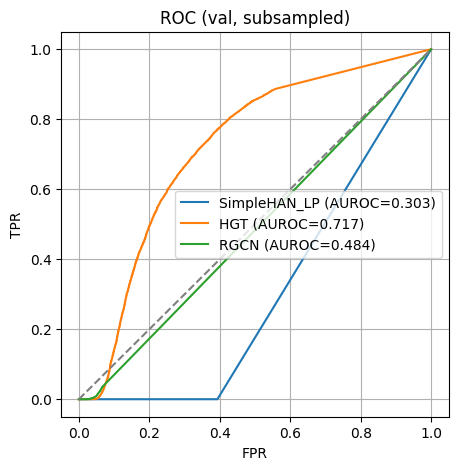

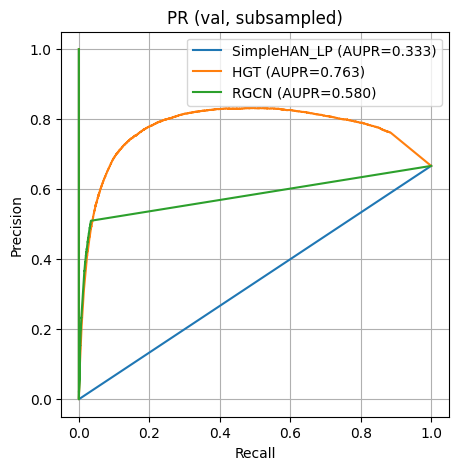

In [110]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, precision_recall_curve

models = {
    #"HAN_LP": model_han,
    "SimpleHAN_LP": model_han_simple,
    "HGT":  model_hgt,
    "RGCN": model_rgcn
}

if (val_loader is None) or (len(val_loader) == 0):
    print("No validation edges available for ROC/PR plotting.")
else:
    curves = {}  # name -> dict with fpr,tpr,roc_auc,rec,prec,pr_auc

    for name, mdl in models.items():
        if mdl is None:
            continue
        mdl.eval()
        probs_all, y_all = [], []
        with torch.no_grad():
            for i, batch in enumerate(val_loader, 1):
                x  = {k: v.to(device_cuda) for k,v in batch.x_dict.items()}
                ei = {k: v.to(device_cuda) for k,v in batch.edge_index_dict.items()}
                y  = batch[REL].edge_label.to(device_cuda).float()
                e_ind = batch[REL].edge_label_index.to(device_cuda)

                h = mdl(x, ei)
                logits = mdl.predict(h, e_ind, REL)
                if logits.numel() == 0:
                    continue
                p = torch.sigmoid(logits)
                n = min(20000, p.numel())
                probs_all.append(p[:n].detach().cpu())
                y_all.append(y[:n].detach().cpu())
                if i >= 25:
                    break

        if len(probs_all) == 0:
            print(f"{name}: no non-empty validation batches for ROC/PR plotting.")
            continue

        probs_all_np = torch.cat(probs_all).numpy()
        y_all_np     = torch.cat(y_all).numpy()

        fpr, tpr, _ = roc_curve(y_all_np, probs_all_np)
        roc_auc = auc(fpr, tpr)
        prec, rec, _ = precision_recall_curve(y_all_np, probs_all_np)
        pr_auc = auc(rec, prec)

        print(f"{name}: Val ROC-AUC (subsample) = {roc_auc:.3f} | PR-AUC = {pr_auc:.3f}")
        curves[name] = {
            "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc,
            "rec": rec, "prec": prec, "pr_auc": pr_auc,
        }

    if len(curves) == 0:
        print("No curves to plot.")
    else:
        # ROC plot
        plt.figure(figsize=(5,5))
        for name, c in curves.items():
            plt.plot(c["fpr"], c["tpr"], label=f"{name} (AUROC={c['roc_auc']:.3f})")
        plt.plot([0,1], [0,1], '--', color='gray')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title("ROC (val, subsampled)")
        plt.legend()
        plt.grid(True)
        plt.show()

        # PR plot
        plt.figure(figsize=(5,5))
        for name, c in curves.items():
            plt.plot(c["rec"], c["prec"], label=f"{name} (AUPR={c['pr_auc']:.3f})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("PR (val, subsampled)")
        plt.legend()
        plt.grid(True)
        plt.show()

#### 10b) Qualitative: top-10 predicted report->device links on TEST split (with metadata)

In [115]:
# Models to compare
models = {
    "HGT":        model_hgt,
    "RGCN":       model_rgcn,
    #"HAN":        model_han,
    "HAN_simple": model_han_simple,
}

model_name = "HGT"  # change this to "RGCN", "HAN", or "HAN_simple"
model = models[model_name]

# Qualitative: top-10 predicted report->device links on TEST split (with metadata)
device_meta = device_keys.set_index("device_id")[[
    "MANUFACTURER_D_NAME","MODEL_NUMBER","BRAND_NAME","GENERIC_NAME","DEVICE_REPORT_PRODUCT_CODE"
]]
manuf_meta  = manuf.set_index("manufacturer_id")[["manufacturer_name"]]
report_meta = report.set_index("report_id")[["report_key"]]

if (test_loader is None) or (len(test_loader) == 0):
    print("No test edges available for qualitative inspection.")
else:
    probs_all, y_all, e_all = [], [], []
    with torch.no_grad():
        for i, batch in enumerate(test_loader, 1):
            x  = {k: v.to(device_cuda) for k,v in batch.x_dict.items()}
            ei = {k: v.to(device_cuda) for k,v in batch.edge_index_dict.items()}
            y  = batch[REL].edge_label.to(device_cuda).float()
            e_ind = batch[REL].edge_label_index.to(device_cuda)

            h = model(x, ei)
            logits = model.predict(h, e_ind, REL)
            if logits.numel() == 0:
                continue
            p = torch.sigmoid(logits)
            probs_all.append(p.detach().cpu())
            y_all.append(y.detach().cpu())
            e_all.append(e_ind.detach().cpu())
            if i >= 50:
                break

    if len(probs_all) == 0:
        print(f"{model_name}: no non-empty test batches for qualitative inspection.")
    else:
        probs_all = torch.cat(probs_all)
        y_all = torch.cat(y_all)
        e_all = torch.cat(e_all, dim=1)

        top_k = 10
        top_idx = torch.argsort(-probs_all)[:top_k]

        rep_ids = e_all[0, top_idx].numpy()
        dev_ids = e_all[1, top_idx].numpy()
        probs   = probs_all[top_idx].numpy()
        labels  = y_all[top_idx].numpy()

        rows = []
        for rid, did, p, y_true in zip(rep_ids, dev_ids, probs, labels):
            r_key = report_meta.loc[rid, "report_key"] if rid in report_meta.index else None
            d_row = device_meta.loc[did] if did in device_meta.index else None
            rows.append({
                "model": model_name,
                "report_id": int(rid),
                "report_key": r_key,
                "device_id": int(did),
                "manufacturer": d_row["MANUFACTURER_D_NAME"] if d_row is not None else None,
                "model_name": d_row["MODEL_NUMBER"] if d_row is not None else None,
                "brand": d_row["BRAND_NAME"] if d_row is not None else None,
                "generic": d_row["GENERIC_NAME"] if d_row is not None else None,
                "product_code": d_row["DEVICE_REPORT_PRODUCT_CODE"] if d_row is not None else None,
                "pred_prob": float(p),
                "label": float(y_true),
            })

        df_qual = pd.DataFrame(rows)
        display(df_qual)

,model,report_id,report_key,device_id,manufacturer,model_name,brand,generic,product_code,pred_prob,label
0,HGT,356,18423493,602,MEDTRONIC PUERTO RICO OPERATIONS CO.,97716,INTELLIS,"STIMULATOR, SPINAL-CORD, TOTALLY IMPLANTED FOR",LGW,0.999462,0.0
1,HGT,260,18423373,713,MEDTRONIC XOMED INC.,NIM4CPB1,NIM VITAL¿ PATIENT INTERFACE 4 CHANNEL,"STIMULATOR, ELECTRICAL, EVOKED RESPONSE",GWF,0.998361,0.0
2,HGT,61,18423137,883,"ALCON RESEARCH, LLC - HUNTINGTON",CCWTT0,CLAREON PANOPTIX TRIFOCAL UV ABSORBING INTRAOC...,"LENS, MULTIFOCAL INTRAOCULAR",MFK,0.998336,0.0
3,HGT,211,18423315,766,MPRI,5076-45,CAPSUREFIX NOVUS LEAD MRI SURESCAN,PERMANENT PACEMAKER ELECTRODE,DTB,0.997886,0.0
4,HGT,121,18423204,664,ZOLL MEDICAL CORPORATION,R SERIES,R SERIES DEFIBRILLATOR,DEFIBRILLATOR/PACEMAKER,MKJ,0.997730,0.0
5,HGT,240,18423348,457,MEDTRONIC XOMED INC.,NIM4CM01,NIM 4.0 CONSOLE,"STIMULATOR, ELECTRICAL, EVOKED RESPONSE",GWF,0.997667,0.0
6,HGT,156,18423240,467,MEDTRONIC SINGAPORE OPERATIONS,5076-52,CAPSUREFIX NOVUS LEAD MRI SURESCAN,PERMANENT PACEMAKER ELECTRODE,DTB,0.997021,0.0
7,HGT,109,18423190,126,BOSTON SCIENTIFIC CORPORATION,7010,QUANTUM MAVERICK,"CATHETERS, TRANSLUMINAL CORONARY ANGIOPLASTY, ...",LOX,0.996794,0.0
8,HGT,237,18423345,153,"SHIRAKAWA OLYMPUS CO., LTD.",GF-UCT260,EVIS LUCERA ULTRASOUND GASTROVIDEOSCOPE,ULTRASOUND GASTROVIDEOSCOPE,ODG,0.996723,0.0
9,HGT,141,18423224,591,ABBOTT,LSP112V,"AVEIR¿ LEADLESS PACEMAKER, RIGHT VENTRICLE",LEADLESS PACEMAKER,PNJ,0.996627,0.0


In [116]:
# Models to compare
models = {
    "HGT":        model_hgt,
    "RGCN":       model_rgcn,
    #"HAN":        model_han,         # if available
    "HAN_simple": model_han_simple,  # SimpleHAN_LP in main notebook
}

model_name = "RGCN"  # change this to "RGCN", "HAN", or "HAN_simple"
model = models[model_name]

# Qualitative: top-10 predicted report->device links on TEST split (with metadata)
device_meta = device_keys.set_index("device_id")[[
    "MANUFACTURER_D_NAME","MODEL_NUMBER","BRAND_NAME","GENERIC_NAME","DEVICE_REPORT_PRODUCT_CODE"
]]
manuf_meta  = manuf.set_index("manufacturer_id")[["manufacturer_name"]]
report_meta = report.set_index("report_id")[["report_key"]]

if (test_loader is None) or (len(test_loader) == 0):
    print("No test edges available for qualitative inspection.")
else:
    probs_all, y_all, e_all = [], [], []
    with torch.no_grad():
        for i, batch in enumerate(test_loader, 1):
            x  = {k: v.to(device_cuda) for k,v in batch.x_dict.items()}
            ei = {k: v.to(device_cuda) for k,v in batch.edge_index_dict.items()}
            y  = batch[REL].edge_label.to(device_cuda).float()
            e_ind = batch[REL].edge_label_index.to(device_cuda)

            h = model(x, ei)
            logits = model.predict(h, e_ind, REL)
            if logits.numel() == 0:
                continue
            p = torch.sigmoid(logits)
            probs_all.append(p.detach().cpu())
            y_all.append(y.detach().cpu())
            e_all.append(e_ind.detach().cpu())
            if i >= 50:
                break

    if len(probs_all) == 0:
        print(f"{model_name}: no non-empty test batches for qualitative inspection.")
    else:
        probs_all = torch.cat(probs_all)
        y_all = torch.cat(y_all)
        e_all = torch.cat(e_all, dim=1)

        top_k = 10
        top_idx = torch.argsort(-probs_all)[:top_k]

        rep_ids = e_all[0, top_idx].numpy()
        dev_ids = e_all[1, top_idx].numpy()
        probs   = probs_all[top_idx].numpy()
        labels  = y_all[top_idx].numpy()

        rows = []
        for rid, did, p, y_true in zip(rep_ids, dev_ids, probs, labels):
            r_key = report_meta.loc[rid, "report_key"] if rid in report_meta.index else None
            d_row = device_meta.loc[did] if did in device_meta.index else None
            rows.append({
                "model": model_name,
                "report_id": int(rid),
                "report_key": r_key,
                "device_id": int(did),
                "manufacturer": d_row["MANUFACTURER_D_NAME"] if d_row is not None else None,
                "model_name": d_row["MODEL_NUMBER"] if d_row is not None else None,
                "brand": d_row["BRAND_NAME"] if d_row is not None else None,
                "generic": d_row["GENERIC_NAME"] if d_row is not None else None,
                "product_code": d_row["DEVICE_REPORT_PRODUCT_CODE"] if d_row is not None else None,
                "pred_prob": float(p),
                "label": float(y_true),
            })

        df_qual = pd.DataFrame(rows)
        display(df_qual)

,model,report_id,report_key,device_id,manufacturer,model_name,brand,generic,product_code,pred_prob,label
0,RGCN,245,18423354,680,MEDTRONIC PUERTO RICO OPERATIONS CO.,97714,SURESCAN,"STIMULATOR, SPINAL-CORD, TOTALLY IMPLANTED FOR",LGW,0.999997,0.0
1,RGCN,269,18423391,390,ABBOTT DIABETES CARE INC,71992-01,LIBRE 2 SENSOR FREESTYLE,FLASH GLUCOSE MONITORING SYSTEM,QLG,0.999994,0.0
2,RGCN,37,18423112,581,MPRI,5076-45,CAPSUREFIX NOVUS LEAD MRI SURESCAN,PERMANENT PACEMAKER ELECTRODE,DTB,0.999988,0.0
3,RGCN,241,18423350,388,MPRI,5076-58,CAPSUREFIX NOVUS LEAD MRI SURESCAN,PERMANENT PACEMAKER ELECTRODE,DTB,0.999976,0.0
4,RGCN,262,18423375,464,"DEXCOM, INC.",9500-155,DEXCOM G7 CONTINUOUS GLUCOSE MONITORING SYSTEM,CONTINUOUS GLUCOSE MONITOR,QBJ,0.999932,0.0
5,RGCN,131,18423214,42,COVIDIEN LP LLC NORTH HAVEN,VLOCL0604,V-LOC 180,"SUTURE, ABSORBABLE, SYNTHETIC, POLYGLYCOLIC AC",GAM,0.999862,0.0
6,RGCN,193,18423289,100,BOSTON SCIENTIFIC CORPORATION,3852,WOLVERINE CORONARY CUTTING BALLOON MONORAIL,"CATHETER, PERCUTANEOUS TRANSLUMINAL CORONARY A...",NWX,0.999851,0.0
7,RGCN,30,18423105,146,BOSTON SCIENTIFIC CORPORATION,24674,MUSTANG,"CATHETER, BILIARY, DIAGNOSTIC",FGE,0.999813,0.0
8,RGCN,22,18423095,700,"MEDTRONIC, INC.",6935M,SPRINT QUATTRO SECURE S MRI SURESCAN,"DEFIBRILLATOR, AUTOMATIC IMPLANTABLE CARDIOVERTER",LWS,0.999596,0.0
9,RGCN,266,18423385,282,MAQUET CARDIOPULMONARY GMBH,BEQ-HLS 5050 USA #SHLS SET ADVANCED 5.0,TUBING SET,"OXYGENATOR, CARDIOPULMONARY BYPASS",DTZ,0.999401,0.0


In [118]:
# Models to compare
models = {
    "HGT":        model_hgt,
    "RGCN":       model_rgcn,
    #"HAN":        model_han,         # if available
    "HAN_simple": model_han_simple,  # SimpleHAN_LP in main notebook
}

model_name = "HAN_simple"  # change this to "RGCN", "HAN", or "HAN_simple"
model = models[model_name]

# Qualitative: top-10 predicted report->device links on TEST split (with metadata)
device_meta = device_keys.set_index("device_id")[[
    "MANUFACTURER_D_NAME","MODEL_NUMBER","BRAND_NAME","GENERIC_NAME","DEVICE_REPORT_PRODUCT_CODE"
]]
manuf_meta  = manuf.set_index("manufacturer_id")[["manufacturer_name"]]
report_meta = report.set_index("report_id")[["report_key"]]

if (test_loader is None) or (len(test_loader) == 0):
    print("No test edges available for qualitative inspection.")
else:
    probs_all, y_all, e_all = [], [], []
    with torch.no_grad():
        for i, batch in enumerate(test_loader, 1):
            x  = {k: v.to(device_cuda) for k,v in batch.x_dict.items()}
            ei = {k: v.to(device_cuda) for k,v in batch.edge_index_dict.items()}
            y  = batch[REL].edge_label.to(device_cuda).float()
            e_ind = batch[REL].edge_label_index.to(device_cuda)

            h = model(x, ei)
            logits = model.predict(h, e_ind, REL)
            if logits.numel() == 0:
                continue
            p = torch.sigmoid(logits)
            probs_all.append(p.detach().cpu())
            y_all.append(y.detach().cpu())
            e_all.append(e_ind.detach().cpu())
            if i >= 50:
                break

    if len(probs_all) == 0:
        print(f"{model_name}: no non-empty test batches for qualitative inspection.")
    else:
        probs_all = torch.cat(probs_all)
        y_all = torch.cat(y_all)
        e_all = torch.cat(e_all, dim=1)

        top_k = 10
        top_idx = torch.argsort(-probs_all)[:top_k]

        rep_ids = e_all[0, top_idx].numpy()
        dev_ids = e_all[1, top_idx].numpy()
        probs   = probs_all[top_idx].numpy()
        labels  = y_all[top_idx].numpy()

        rows = []
        for rid, did, p, y_true in zip(rep_ids, dev_ids, probs, labels):
            r_key = report_meta.loc[rid, "report_key"] if rid in report_meta.index else None
            d_row = device_meta.loc[did] if did in device_meta.index else None
            rows.append({
                "model": model_name,
                "report_id": int(rid),
                "report_key": r_key,
                "device_id": int(did),
                "manufacturer": d_row["MANUFACTURER_D_NAME"] if d_row is not None else None,
                "model_name": d_row["MODEL_NUMBER"] if d_row is not None else None,
                "brand": d_row["BRAND_NAME"] if d_row is not None else None,
                "generic": d_row["GENERIC_NAME"] if d_row is not None else None,
                "product_code": d_row["DEVICE_REPORT_PRODUCT_CODE"] if d_row is not None else None,
                "pred_prob": float(p),
                "label": float(y_true),
            })

        df_qual = pd.DataFrame(rows)
        display(df_qual)

,model,report_id,report_key,device_id,manufacturer,model_name,brand,generic,product_code,pred_prob,label
0,HAN_simple,155,18423239,731,MEDTRONIC MINIMED,MMT-7040A,SENSOR MMT-7040A GUARDIAN4 5PK US,"AUTOMATED INSULIN DOSING DEVICE SYSTEM, SINGLE...",OZP,0.999346,0.0
1,HAN_simple,257,18423370,574,"DEXCOM, INC.",9445-24,DEXCOM G6 CONTINUOUS GLUCOSE MONITORING SYSTEM,CONTINUOUS GLUCOSE MONITOR,QBJ,0.999054,0.0
2,HAN_simple,145,18423228,77,BOSTON SCIENTIFIC CORPORATION,24691,COYOTE ES,"CATHETER, ANGIOPLASTY, PERIPHERAL, TRANSLUMINAL",LIT,0.998738,0.0
3,HAN_simple,175,18423265,46,COVIDIEN LP LLC NORTH HAVEN,030459,ENDO GIA,"STAPLE, IMPLANTABLE",GDW,0.998318,0.0
4,HAN_simple,168,18423255,795,MPRI,6935M62,SPRINT QUATTRO SECURE S MRI SURESCAN,"DEFIBRILLATOR, AUTOMATIC IMPLANTABLE CARDIOVERTER",LWS,0.998101,0.0
5,HAN_simple,59,18423135,594,ABBOTT DIABETES CARE INC,71940-01H,FREESTYLE LIBRE 14 DAY,FLASH GLUCOSE MONITORING SYSTEM,PZE,0.998075,0.0
6,HAN_simple,174,18423262,202,BOSTON SCIENTIFIC CORPORATION,4471,FINELINE II EZ STEROX,PERMANENT PACEMAKER ELECTRODE,DTB,0.997206,0.0
7,HAN_simple,166,18423252,114,BOSTON SCIENTIFIC CORPORATION,7311,NC EMERGE,"CATHETERS, TRANSLUMINAL CORONARY ANGIOPLASTY, ...",LOX,0.996572,0.0
8,HAN_simple,1,18423066,277,"ST. JUDE MEDICAL, INC.(CRM-SYLMAR)",CD3371-40QC,QUADRA ASSURA MP ICD,No Match,NIK,0.995849,0.0
9,HAN_simple,242,18423351,82,BOSTON SCIENTIFIC CORPORATION,24674,MUSTANG,"CATHETER, BILIARY, DIAGNOSTIC",FGE,0.994743,0.0


#### 10c) Fetch top 10 predicted links

In [119]:
models = {
    "HGT":        model_hgt,
    "RGCN":       model_rgcn,
    #"HAN":        model_han,
    "HAN_simple": model_han_simple,
}

model_name = "HGT"  # choose: "HGT", "RGCN", "HAN", "HAN_simple"
model = models[model_name]

# Qualitative: top-10 predicted report->device links on val split
if (val_loader is None) or (len(val_loader) == 0):
    print("No validation edges available for qualitative inspection.")
else:
    batch = next(iter(val_loader))
    x  = {k: v.to(device_cuda) for k,v in batch.x_dict.items()}
    ei = {k: v.to(device_cuda) for k,v in batch.edge_index_dict.items()}
    y  = batch[REL].edge_label.to(device_cuda).float()
    e_ind = batch[REL].edge_label_index.to(device_cuda)

    with torch.no_grad():
        h = model(x, ei)
        logits = model.predict(h, e_ind, REL)
        if logits.numel() == 0:
            print(f"{model_name}: validation batch contained no edges for REL.")
        else:
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            top = np.argsort(-probs)[:10]
            pairs = list(
                zip(
                    e_ind[0, top].cpu().numpy(),
                    e_ind[1, top].cpu().numpy(),
                    probs[top],
                    y[top].cpu().numpy(),
                )
            )
            df_top = pd.DataFrame(pairs, columns=["report_id","device_id","pred_prob","label"])
            df_top.insert(0, "model", model_name)
            display(df_top)


,model,report_id,device_id,pred_prob,label
0,HGT,210,676,0.999706,0.0
1,HGT,134,681,0.995959,0.0
2,HGT,184,297,0.986098,0.0
3,HGT,49,587,0.982074,0.0
4,HGT,73,554,0.979277,0.0
5,HGT,79,706,0.962833,0.0
6,HGT,195,645,0.959301,0.0
7,HGT,219,838,0.950667,0.0
8,HGT,94,765,0.918155,0.0
9,HGT,180,524,0.905405,0.0


In [120]:
models = {
    "HGT":        model_hgt,
    "RGCN":       model_rgcn,
    #"HAN":        model_han,
    "HAN_simple": model_han_simple,
}

model_name = "RGCN"  # choose: "HGT", "RGCN", "HAN", "HAN_simple"
model = models[model_name]

# Qualitative: top-10 predicted report->device links on val split
if (val_loader is None) or (len(val_loader) == 0):
    print("No validation edges available for qualitative inspection.")
else:
    batch = next(iter(val_loader))
    x  = {k: v.to(device_cuda) for k,v in batch.x_dict.items()}
    ei = {k: v.to(device_cuda) for k,v in batch.edge_index_dict.items()}
    y  = batch[REL].edge_label.to(device_cuda).float()
    e_ind = batch[REL].edge_label_index.to(device_cuda)

    with torch.no_grad():
        h = model(x, ei)
        logits = model.predict(h, e_ind, REL)
        if logits.numel() == 0:
            print(f"{model_name}: validation batch contained no edges for REL.")
        else:
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            top = np.argsort(-probs)[:10]
            pairs = list(
                zip(
                    e_ind[0, top].cpu().numpy(),
                    e_ind[1, top].cpu().numpy(),
                    probs[top],
                    y[top].cpu().numpy(),
                )
            )
            df_top = pd.DataFrame(pairs, columns=["report_id","device_id","pred_prob","label"])
            df_top.insert(0, "model", model_name)
            display(df_top)


,model,report_id,device_id,pred_prob,label
0,RGCN,61,623,0.999705,0.0
1,RGCN,283,557,0.986008,0.0
2,RGCN,20,541,0.976299,0.0
3,RGCN,298,7,0.969701,0.0
4,RGCN,103,153,0.956194,0.0
5,RGCN,153,601,0.925922,0.0
6,RGCN,111,347,0.898563,0.0
7,RGCN,57,240,0.895157,0.0
8,RGCN,138,143,0.863248,0.0
9,RGCN,157,488,0.835401,0.0


In [121]:
models = {
    "HGT":        model_hgt,
    "RGCN":       model_rgcn,
    #"HAN":        model_han,
    "HAN_simple": model_han_simple,
}

model_name = "HAN_simple"  # choose: "HGT", "RGCN", "HAN", "HAN_simple"
model = models[model_name]

# Qualitative: top-10 predicted report->device links on val split
if (val_loader is None) or (len(val_loader) == 0):
    print("No validation edges available for qualitative inspection.")
else:
    batch = next(iter(val_loader))
    x  = {k: v.to(device_cuda) for k,v in batch.x_dict.items()}
    ei = {k: v.to(device_cuda) for k,v in batch.edge_index_dict.items()}
    y  = batch[REL].edge_label.to(device_cuda).float()
    e_ind = batch[REL].edge_label_index.to(device_cuda)

    with torch.no_grad():
        h = model(x, ei)
        logits = model.predict(h, e_ind, REL)
        if logits.numel() == 0:
            print(f"{model_name}: validation batch contained no edges for REL.")
        else:
            probs = torch.sigmoid(logits).detach().cpu().numpy()
            top = np.argsort(-probs)[:10]
            pairs = list(
                zip(
                    e_ind[0, top].cpu().numpy(),
                    e_ind[1, top].cpu().numpy(),
                    probs[top],
                    y[top].cpu().numpy(),
                )
            )
            df_top = pd.DataFrame(pairs, columns=["report_id","device_id","pred_prob","label"])
            df_top.insert(0, "model", model_name)
            display(df_top)


,model,report_id,device_id,pred_prob,label
0,HAN_simple,236,122,0.987992,0.0
1,HAN_simple,147,503,0.982154,0.0
2,HAN_simple,95,175,0.974508,0.0
3,HAN_simple,112,704,0.971735,0.0
4,HAN_simple,81,99,0.966432,0.0
5,HAN_simple,14,691,0.964791,0.0
6,HAN_simple,170,236,0.964283,0.0
7,HAN_simple,57,499,0.951046,0.0
8,HAN_simple,105,202,0.925990,0.0
9,HAN_simple,45,672,0.911251,0.0


###10d) Relation importance perturbation test: How much does the model rely on manufacturer -> device edges?

In [122]:
@torch.no_grad()
def evaluate_with_mfr_drop(model, drop_frac=0.5):
    from copy import deepcopy

    if test_loader is None:
        return {"au": 0.0, "f1": 0.0}

    # shallow copy - avoid messing up training graph
    data_pert = deepcopy(data)

    et = ("manufacturer", "makes", "device")
    if et not in data_pert.edge_types:
        print("No manufacturer->device relation present.")
        return evaluate(model, test_loader)

    ei = data_pert[et].edge_index
    E = ei.size(1)
    k_keep = int(E * (1.0 - drop_frac))
    keep_idx = torch.randperm(E)[:k_keep]
    data_pert[et].edge_index = ei[:, keep_idx]

    # Also drop reverse direction if present
    rev_et = ("device", "made_by", "manufacturer")
    if rev_et in data_pert.edge_types:
        ei_rev = data_pert[rev_et].edge_index
        E_rev = ei_rev.size(1)
        keep_idx_rev = torch.randperm(E_rev)[:k_keep]
        data_pert[rev_et].edge_index = ei_rev[:, keep_idx_rev]

    # Build a temporary test loader on perturbed graph, same edges/labels
    pert_test_loader = LinkNeighborLoader(
        data=data_pert,
        num_neighbors=fanouts,
        edge_label_index=(REL, temporal_edges["test"]),
        edge_label=torch.ones(temporal_edges["test"].size(1), dtype=torch.float),
        neg_sampling_ratio=0.5,
        batch_size=1024,
        shuffle=False,
        replace=False,
        pin_memory=False,
        num_workers=0,
        persistent_workers=False,
    )

    return evaluate(model, pert_test_loader)


In [124]:
drop_frac = 0.5  # perturbation strength

for name, mdl in models.items():
    if mdl is None:
        continue

    # Baseline on the original test_loader
    base = evaluate(mdl, test_loader)

    # Perturbed evaluation with manufacturer->device edges dropped
    pert = evaluate_with_mfr_drop(mdl, drop_frac=drop_frac)

    print(f"[{name}] Base test  : AU={base['au']:.3f}, F1={base['f1']:.3f}")
    print(f"[{name}] After drop: AU={pert['au']:.3f}, F1={pert['f1']:.3f}")
    print("-" * 80)


NameError: name 'evaluate' is not defined

###Local neighborhood visualization

In [123]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_report_neighborhood(report_id, max_neighbors=20):
    # Build a small bipartite graph: report, its devices, and associated manufacturers
    G = nx.DiGraph()

    # Add the report node
    G.add_node(f"R{report_id}", type="report")

    # find devices linked to this report
    mask = (edge_train[0] == report_id)  # or edge_test if you prefer test
    dev_ids = edge_train[1, mask].cpu().numpy()
    dev_ids = dev_ids[:max_neighbors]

    for d in dev_ids:
        G.add_node(f"D{d}", type="device")
        G.add_edge(f"R{report_id}", f"D{d}", rel="mentions")

        # manufacturers for this device
        m_mask = (edge_manuf_device[1] == d)
        m_ids = edge_manuf_device[0, m_mask].cpu().numpy()
        for m in m_ids[:2]:  # limit for clarity
            G.add_node(f"M{m}", type="manufacturer")
            G.add_edge(f"M{m}", f"D{d}", rel="makes")

    # Layout and draw
    pos = nx.spring_layout(G, seed=42)
    colors = []
    for n, data_n in G.nodes(data=True):
        if data_n["type"] == "report":
            colors.append("tab:red")
        elif data_n["type"] == "device":
            colors.append("tab:blue")
        else:
            colors.append("tab:green")

    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500, arrows=False, font_size=8)
    edge_labels = nx.get_edge_attributes(G, "rel")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.title(f"Local neighborhood for report_id={report_id}")
    plt.axis("off")
    plt.show()


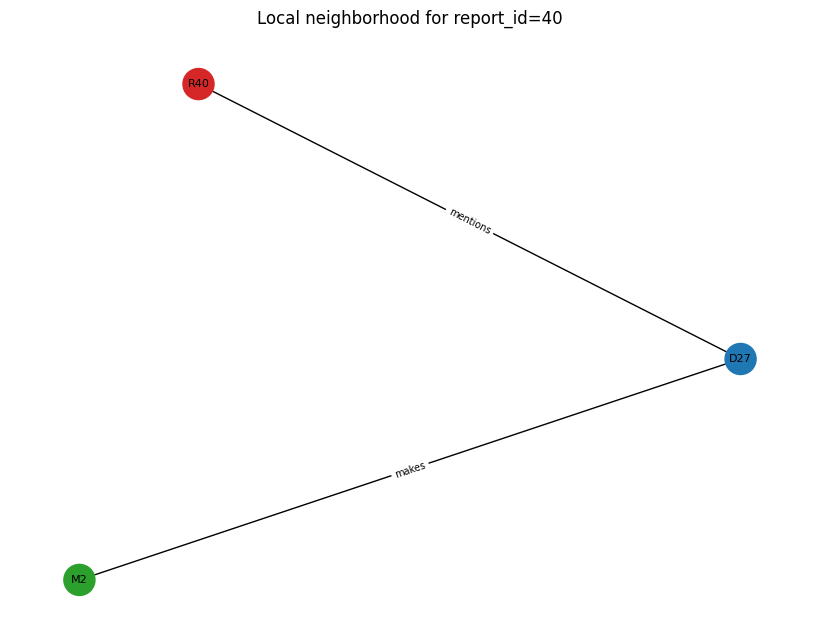

In [126]:
visualize_report_neighborhood(report_id=40)

###Visualizing the network

####Convert ipynb to html (optional)

In [ ]:
!jupyter nbconvert --to html /content/project.ipynb